- Test the robustness of findings under different high-risk group sizes: s_H=10^{-2,-1,1}; half-life=2 day; network of 10^5 nodes
- Reproduce Fig.4 in the paper 

In [14]:
import simsom.utils as utils
import numpy as np
import pandas as pd
import os
import glob
from plot_helpers import (
    get_agg_metric,
    patch_violinplot,
    point_violinplot,
    bonferroni_correction,
    get_corrected_p,
    get_annotation,
    add_annotation,
    BLUEPALETTE,
)

# Read data

In [15]:
exp_type = "vary_group_size"
data = pd.read_parquet(f"data/{exp_type}.parquet")

# Calculate pct change: 
metric-baseline_median / (baseline_median)

In [16]:
# dummy column to count the number of observations
data["illegal_prob"] = 1
baseline = data[data.half_life == -1]

baseline = get_agg_metric(
    baseline,
    group_key=["s_H"],
    new_col_prefix="baseline",
    metrics=[
        "illegal_frac",
        "unique_illegal_frac",
    ],
    retain_keys=["illegal_prob", "half_life"],
)

/geode2/home/u015/baotruon/BigRed200/simsom_removal/experiments/figures/plot_helpers.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{metric}_std"] = df[metric]


In [17]:
baseline

,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,s_H,baseline_no_observations,half_life
0,0.009197,0.010037,0.001581,0.001445,0.1,60,-1.0
1,0.009766,0.010157,0.002843,0.001226,1.0,60,-1.0
2,0.011255,0.010233,0.008117,0.001704,10.0,60,-1.0


## Get pct change

In [25]:
results = data[data.half_life != -1]
baseline = baseline.drop(columns=["half_life"])
results = results.merge(baseline, on="s_H", how="left")

In [26]:
results.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,s_H,half_life,illegal_prob,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations
0,0.007029,0.007675,1046,42,0.1,8.0,1,0.009197,0.010037,0.001581,0.001445,60
1,0.007719,0.008315,1157,45,1.0,8.0,1,0.009766,0.010157,0.002843,0.001226,60
2,0.008413,0.008539,1259,45,10.0,8.0,1,0.011255,0.010233,0.008117,0.001704,60
3,0.008363,0.007583,1252,42,0.1,8.0,1,0.009197,0.010037,0.001581,0.001445,60
4,0.006379,0.005966,954,32,1.0,8.0,1,0.009766,0.010157,0.002843,0.001226,60


In [27]:
results = results[~results.unique_illegal_frac.isna()]

In [28]:
metric = "unique_illegal_frac"
results["pct_change"] = (
    (results[f"baseline_{metric}_mean"] - results[metric])
    / results[f"baseline_{metric}_mean"]
    * 100
)

In [29]:
results.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,s_H,half_life,illegal_prob,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
0,0.007029,0.007675,1046,42,0.1,8.0,1,0.009197,0.010037,0.001581,0.001445,60,23.529129
1,0.007719,0.008315,1157,45,1.0,8.0,1,0.009766,0.010157,0.002843,0.001226,60,18.133775
2,0.008413,0.008539,1259,45,10.0,8.0,1,0.011255,0.010233,0.008117,0.001704,60,16.556216
3,0.008363,0.007583,1252,42,0.1,8.0,1,0.009197,0.010037,0.001581,0.001445,60,24.454125
4,0.006379,0.005966,954,32,1.0,8.0,1,0.009766,0.010157,0.002843,0.001226,60,41.263069


# Statistical significance: pct change 

In [30]:
from scipy.stats import mannwhitneyu

probs = sorted(results.s_H.dropna().unique())
pairs = [
    (probs[i], probs[j]) for i in range(len(probs)) for j in range(i + 1, len(probs))
]
pairs

[(0.1, 1.0), (0.1, 10.0), (1.0, 10.0)]

## Filter tau=2

In [31]:
focal_col = "s_H"  # column being tested in the significance test
focal = results[results.half_life == 2]
stat_res = []
for pair in pairs:
    pop1 = focal[focal[focal_col] == pair[0]]["pct_change"]
    pop2 = focal[focal[focal_col] == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

tau2_res = focal

In [32]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(0.1, 1.0)",216.0,0.678306,1.000000
1,"(0.1, 10.0)",173.0,0.477691,1.000000
2,"(1.0, 10.0)",156.0,0.242270,0.726809


## Filter tau=8

In [ ]:
focal = results[results.half_life == 8]
stat_res = []
for pair in pairs:
    pop1 = focal[focal.s_H == pair[0]]["pct_change"]
    pop2 = focal[focal.s_H == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

tau8_res = focal

In [34]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(0.1, 1.0)",193.0,0.861987,1.0
1,"(0.1, 10.0)",201.0,0.989332,1.0
2,"(1.0, 10.0)",206.0,0.883057,1.0


# Plot in panel

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use("stylesheet.mplstyle")
PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
fpath = os.path.join(PLOT_DIR, f"pct_change_s_H_combine")

p-values:           pair      U         p  corrected_p
0   (0.1, 1.0)  216.0  0.678306     1.000000
1  (0.1, 10.0)  173.0  0.477691     1.000000
2  (1.0, 10.0)  156.0  0.242270     0.726809
Significant pairs (p<0.001):  []
p-values:           pair      U         p  corrected_p
0   (0.1, 1.0)  193.0  0.861987          1.0
1  (0.1, 10.0)  201.0  0.989332          1.0
2  (1.0, 10.0)  206.0  0.883057          1.0
Significant pairs (p<0.001):  []


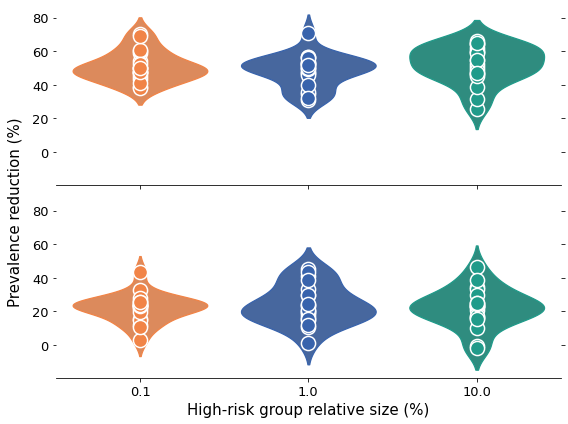

In [39]:
plot_dfs = [tau2_res, tau8_res]
y_label = "Prevalence reduction (%)"

sig_level = 0.001
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
probs = []
for idx, plot_data in enumerate(plot_dfs):
    ax = axs[idx]
    if idx == 0:
        probs = sorted(focal.s_H.unique())

    # Create the violin plot
    violin = sns.violinplot(
        ax=ax,
        data=plot_data,
        x="s_H",
        y="pct_change",
        order=probs,
        inner="point",
        palette=BLUEPALETTE[: len(probs)],
        hue="s_H",
        legend=False,
    )
    if idx == len(plot_dfs) - 1:
        violin.set_xlabel("High-risk group relative size (%)")
    else:
        violin.set_xlabel("")
    violin.set_ylabel("")

    patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
    point_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
    ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
    sns.despine(top=True, left=True, bottom=False)

    ## TEST SIGNIFICANCE
    stats, significant_pairs = get_corrected_p(
        plot_data, focal_col="s_H", sig_level=sig_level
    )
    significant_pairs = [
        i for i in significant_pairs if i[0] in probs and i[1] in probs
    ]
    # Add annotations for significant pairs
    y_max = plot_data["pct_change"].max()
    for x1, x2 in significant_pairs:
        stat, p = stats[stats["pair"] == (x1, x2)][["U", "corrected_p"]].values[0]
        if p < sig_level:
            y = y_max + 5  # Adjust the y position for the annotation
            add_annotation(ax, probs.index(x1), probs.index(x2), y, get_annotation(p))
            print(f"Pair ( {x1}, {x2} ): p-value: {p:.2e}")
            y_max += 10  # Increment y_max for the next annotation

    # ax.set_ylim(0, 100)
fig.supylabel(y_label, fontsize=15)
# Saving
plt.tight_layout()

if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()